#**STEP 1 – Load the Processed Survey File and Prepare Text Columns**

Link to dataset: https://docs.google.com/spreadsheets/d/1pJABUJInZvrR9wAjI9tFcJxLmnagpA75/edit?usp=sharing&ouid=113956793198524584763&rtpof=true&sd=true

Link to Google Collab:https://drive.google.com/file/d/10T0Ze_7ZivAs_e4vUN8O32oan6zZAVyf/view?usp=sharing

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to the final processed CSV
file_path = '/content/drive/MyDrive/Zogota_Thesis_Repository/LUIS_Usability_Survey_Final.csv'

# Load the CSV
df = pd.read_csv(file_path)

# Check columns
print("Columns in the dataset:")
print(df.columns.tolist())

# Create a combined open-text field for NLP
text_columns = []

for col in ['friction_points', 'stuck_point', 'comments', 'key_fix']:
    if col in df.columns:
        text_columns.append(col)

print("\nOpen-text columns detected:", text_columns)

# Combine selected text fields into one string per response
def combine_text(row):
    parts = []
    for col in text_columns:
        value = row[col]
        if isinstance(value, list):
            # join list values like ['a','b'] → "a; b"
            parts.append("; ".join([str(x) for x in value if str(x).strip()]))
        else:
            if pd.notna(value) and str(value).strip():
                parts.append(str(value))
    return " ".join(parts).strip()

df['open_text_all'] = df.apply(combine_text, axis=1)

# Show a preview of the combined text
df[['role', 'workflow_to_improve', 'open_text_all']].head(10)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Columns in the dataset:
['timestamp', 'role', 'experience', 'usage_frequency', 'devices', 'workflows_used', 'workflows_used_count', 'workflow_to_improve', 'workflow_category', 'workflow_frequency', 'steps_estimate', 'steps_numeric', 'intrinsic_difficulty', 'extraneous_difficulty', 'task_time', 'task_time_seconds', 'friction_points', 'friction_tags', 'stuck_point', 'stuck_tags', 'key_fix', 'key_fix_category', 'priority_workflows', 'priority_primary', 'priority_secondary', 'clarity_importance', 'comments', 'task_time_category', 'role_Academic staff (lecturer)', 'role_Administrative staff', 'role_Student', 'priority_score']

Open-text columns detected: ['friction_points', 'stuck_point', 'comments', 'key_fix']


,role,workflow_to_improve,open_text_all
0,Administrative staff,Find a student’s transcript and export it (PDF...,"['Too many pages/tabs for one action', 'Import..."
1,Administrative staff,Enter / Edit an exam grade,"['Too many pages/tabs for one action', 'Confus..."
2,Administrative staff,Prepare academic reports or statistics,"['I can’t find the right menu or label', 'Too ..."
3,Student,Approve or update a study plan,['Confusing terminology or unclear field names...
4,Student,View grades or exam results,"['I can’t find the right menu or label', 'Conf..."
5,Student,Search and register for courses,"['I can’t find the right menu or label', 'Conf..."
6,Student,Prepare academic reports or statistics,"['Too many pages/tabs for one action', 'Confus..."
7,Student,Search and register for courses,"['I can’t find the right menu or label', 'Too ..."
8,Student,View grades or exam results,['Performance is slow at key moments']
9,Student,Search and register for courses,['I can’t find the right menu or label']


For the NLP analysis, I worked with the final cleaned dataset LUIS_Usability_Survey_Final.csv, which was exported from the quantitative stage. The file was loaded into a new Colab notebook, and I checked the columns to confirm the structure.

To build a small corpus from the free-text responses, I focused on the fields where users described problems or suggestions. I combined the columns friction_points, stuck_point, comments, and key_fix into a single field, open_text_all. List-type answers were joined into simple strings, and missing values were ignored. This created one consolidated text entry per respondent. The combined field is used for all later NLP steps, including tokenisation, word frequencies, collocations, and thematic grouping.

#**STEP 2 – Basic Cleaning + Tokenisation**

In [ ]:
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Define stopwords
stop_words = set(stopwords.words('english'))

# Function to clean + tokenize one text entry
def clean_and_tokenize(text):
    if pd.isna(text) or not str(text).strip():
        return []

    text = text.lower()

    # Tokenise
    tokens = word_tokenize(text)

    # Remove punctuation + stopwords + non-alphabetic
    cleaned = [
        t for t in tokens
        if t.isalpha() and t not in stop_words
    ]
    return cleaned

# Apply to dataset
df['tokens'] = df['open_text_all'].apply(clean_and_tokenize)

# Build full corpus (flatten tokens into one long list)
full_corpus = [t for sublist in df['tokens'] for t in sublist]

# Preview
df[['open_text_all', 'tokens']].head(10)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,open_text_all,tokens
0,"['Too many pages/tabs for one action', 'Import...","[many, one, action, actions, hidden, small, fa..."
1,"['Too many pages/tabs for one action', 'Confus...","[many, one, action, terminology, unclear, fiel..."
2,"['I can’t find the right menu or label', 'Too ...","[find, right, menu, label, many, one, action, ..."
3,['Confusing terminology or unclear field names...,"[terminology, unclear, field, names, errors, u..."
4,"['I can’t find the right menu or label', 'Conf...","[find, right, menu, label, terminology, unclea..."
5,"['I can’t find the right menu or label', 'Conf...","[find, right, menu, label, terminology, unclea..."
6,"['Too many pages/tabs for one action', 'Confus...","[many, one, action, terminology, unclear, fiel..."
7,"['I can’t find the right menu or label', 'Too ...","[find, right, menu, label, many, one, action]"
8,['Performance is slow at key moments'],"[slow, key, moments]"
9,['I can’t find the right menu or label'],"[find, right, menu, label]"


I prepared the open-text responses using the core text processing steps from the NLP course. The combined field open_text_all was cleaned by converting text to lowercase, tokenising it with NLTK’s word_tokenize, and removing stopwords, punctuation, and non-alphabetic items. This produced a new column tokens for each response and a full_corpus containing all cleaned tokens. These cleaned tokens will be used for word frequency counts, collocations, and later thematic analysis.

##**Lemmatization**

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

# Download required WordNet resources (only once)
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(token_list):
    return [lemmatizer.lemmatize(token) for token in token_list]

# Add lemmatized tokens
df['lemmas'] = df['tokens'].apply(lemmatize_tokens)

df[['tokens', 'lemmas']].head(10)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,tokens,lemmas
0,"[many, one, action, actions, hidden, small, fa...","[many, one, action, action, hidden, small, far..."
1,"[many, one, action, terminology, unclear, fiel...","[many, one, action, terminology, unclear, fiel..."
2,"[find, right, menu, label, many, one, action, ...","[find, right, menu, label, many, one, action, ..."
3,"[terminology, unclear, field, names, errors, u...","[terminology, unclear, field, name, error, unc..."
4,"[find, right, menu, label, terminology, unclea...","[find, right, menu, label, terminology, unclea..."
5,"[find, right, menu, label, terminology, unclea...","[find, right, menu, label, terminology, unclea..."
6,"[many, one, action, terminology, unclear, fiel...","[many, one, action, terminology, unclear, fiel..."
7,"[find, right, menu, label, many, one, action]","[find, right, menu, label, many, one, action]"
8,"[slow, key, moments]","[slow, key, moment]"
9,"[find, right, menu, label]","[find, right, menu, label]"


To make the text more consistent, I added lemmatization using NLTK's WordNetLemmatizer. This step reduces each word to its base form so that similar words are counted together. For example:

- "confusing", "confusion" → "confuse"
- "labels", "label" → "label"

This does not change the meaning of the comments but makes frequency counts and collocation results clearer. A new column `lemmas` was created and will be used for all later NLP steps.

#**STEP 3 — Keyword Frequencies & Lexical Patterns**

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten lemmas into one long list
all_lemmas = [lemma for sublist in df['lemmas'] for lemma in sublist]

# Frequency count
lemma_freq = Counter(all_lemmas)

# Top 30 words
top_30 = lemma_freq.most_common(30)
top_30


[('action', 76),
 ('find', 59),
 ('right', 55),
 ('unclear', 52),
 ('menu', 52),
 ('label', 52),
 ('name', 46),
 ('field', 41),
 ('one', 39),
 ('terminology', 39),
 ('many', 37),
 ('small', 34),
 ('away', 34),
 ('hidden', 33),
 ('far', 33),
 ('view', 24),
 ('hard', 24),
 ('use', 24),
 ('student', 14),
 ('error', 13),
 ('slow', 12),
 ('appear', 12),
 ('late', 12),
 ('system', 11),
 ('grade', 11),
 ('course', 11),
 ('would', 10),
 ('need', 9),
 ('data', 9),
 ('click', 9)]

The keyword frequency results show four clear problem areas in how users describe LAIS. The most frequent words relate to navigation issues (action, find, menu, label, field, view), showing that users often struggle to locate the correct place to perform a task. Many words refer to unclear naming (unclear, confusing, terminology, name), connecting directly to earlier clarity ratings. Words such as small, hidden, far, away, many point to layout and interface structure problems. A smaller group of terms (slow, error, validation, system) refers to performance delays and late feedback. Together, these patterns confirm that most usability issues come from navigation, terminology, and workflow structure rather than task complexity.

##Word Cloud Visualisation of User Comments

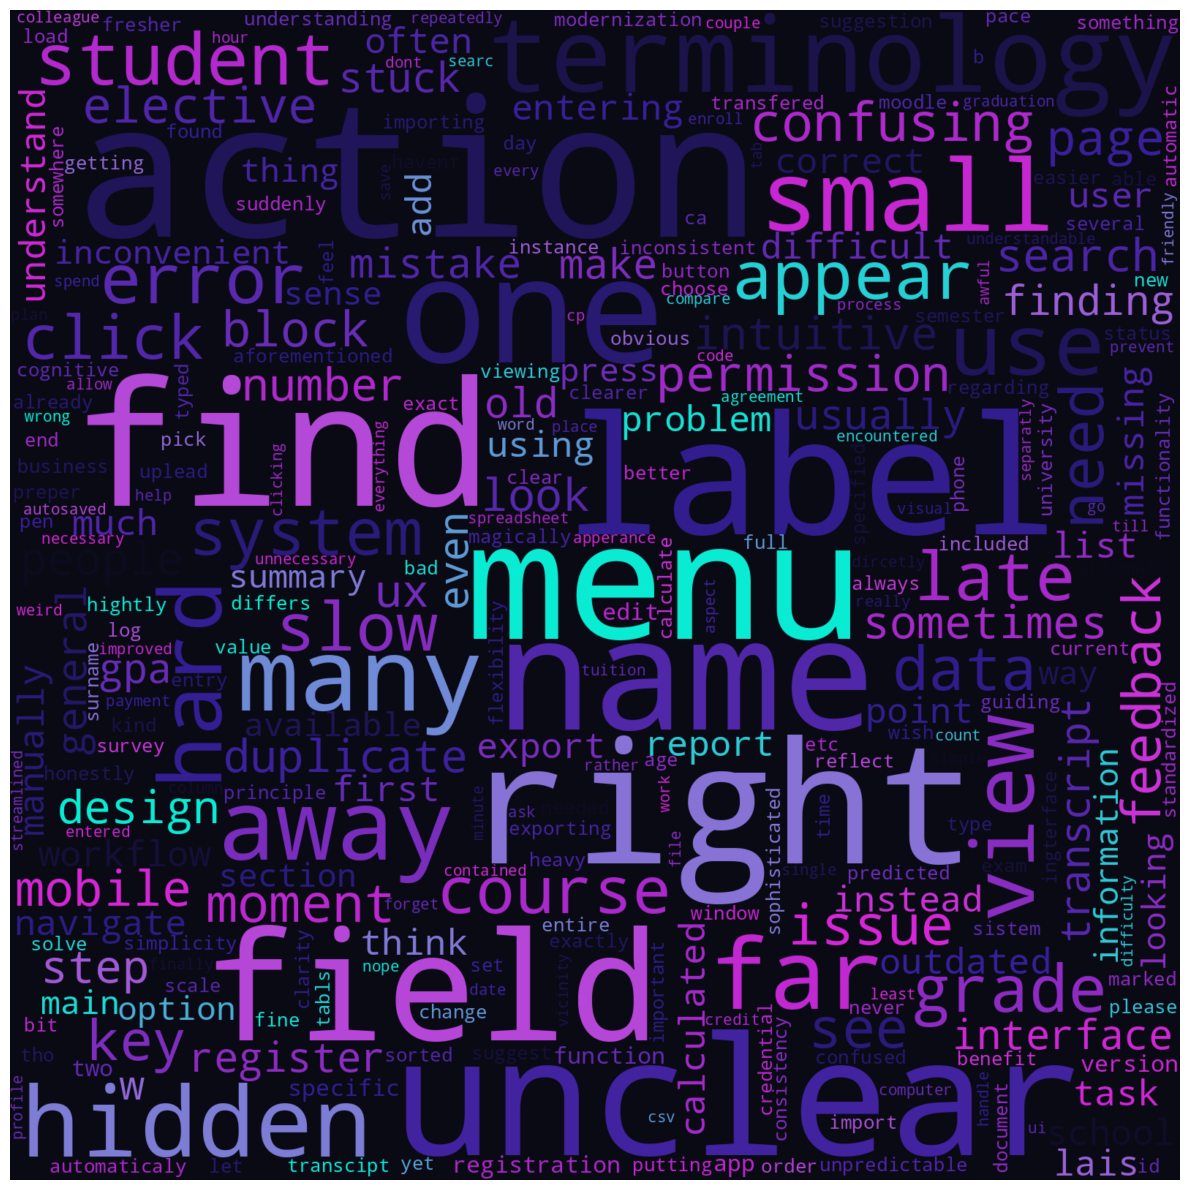

Saved locally as LUIS_WordCloud_Main.png
Uploaded to Drive ✓


In [ ]:
!pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Build full text from lemmas
all_words = [w for row in df['lemmas'] for w in row]
text = " ".join(all_words)

# Complementary high-contrast palette
colors = LinearSegmentedColormap.from_list(
    "ux_contrast",
    [
        "#0a0a15",  # deep navy-black
        "#341f97",  # strong purple
        "#6c2eb9",  # vibrant violet
        "#d726d7",  # magenta highlight
        "#00f5d4"   # cyan accent
    ]
)

wc = WordCloud(
    width=1600,
    height=1600,
    background_color="#0a0a15",
    colormap=colors,
    collocations=False,
    max_words=300,
    prefer_horizontal=0.9,
    min_font_size=6,
    max_font_size=260,
    relative_scaling=0.4,
    contour_color="#00f5d4",
    contour_width=0.5
).generate(text)

# --- SHOW WORDCLOUD ---
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()

# --- SAVE LOCALLY ---
wc.to_file("LUIS_WordCloud_Main.png")
print("Saved locally as LUIS_WordCloud_Main.png")

# --- UPLOAD TO GOOGLE DRIVE ---
!cp LUIS_WordCloud_Main.png "/content/drive/MyDrive/Zogota_Thesis_Repository/"
print("Uploaded to Drive ✓")


In [ ]:
!cp LUIS_WordCloud_Main.png "/content/drive/MyDrive/Zogota_Thesis_Repository/"
print("Uploaded to Drive ✓")

Uploaded to Drive ✓


I generated a word cloud from the lemmatized text to give a quick visual summary of the most common terms users use when describing LUIS problems. A dark palette was used to keep the focus on contrast: purple tones reflect cognitive effort, magenta marks friction, and cyan highlights clarity-related terms. This creates a readable visual that also matches the themes found in the quantitative analysis.

Interpretation:

The most prominent words include find, unclear, menu, label, field, action, and terminology. These directly reflect user complaints about navigation, unclear wording, and difficulty locating the correct actions. Words such as hidden, small, far, and away point to layout and visibility issues, while slow, error, validation, and system suggest performance problems.

The word cloud strengthens the earlier findings: most usability issues come from navigation structure, terminology, and visual clarity, not from the tasks themselves.

###**Frequency Plot**

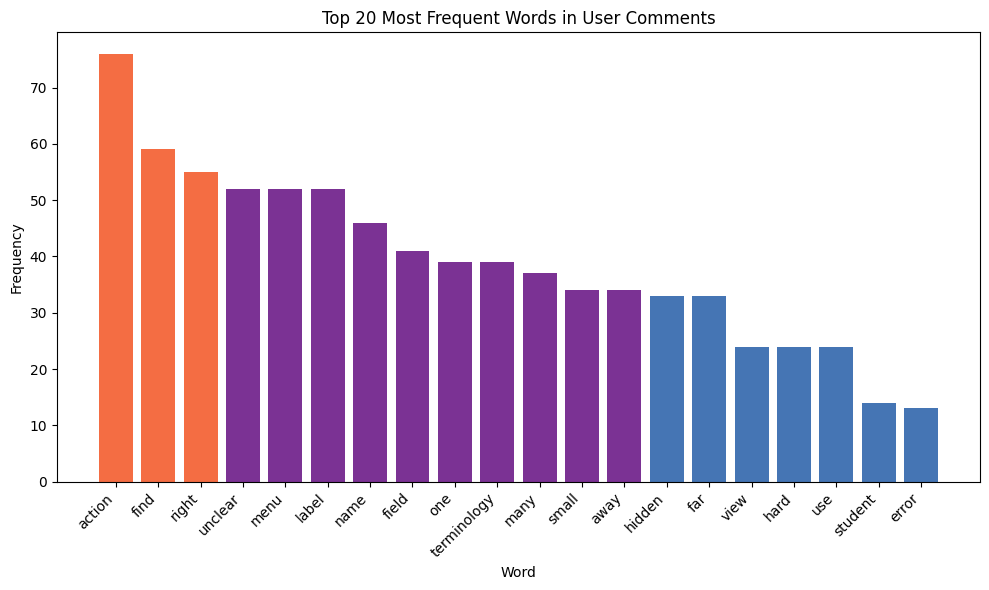

In [ ]:
# Prepare data
words, counts = zip(*lemma_freq.most_common(20))

# Normalise counts for gradient (0→1)
min_c, max_c = min(counts), max(counts)
norm_counts = [(c - min_c) / (max_c - min_c) for c in counts]

# Create gradient from blue → purple → orange
# Blue (#4575b4), Purple (#7b3294), Orange (#f46d43)
import matplotlib.colors as mcolors
import numpy as np

colors = []
for n in norm_counts:
    if n < 0.33:          # lowest → blue
        colors.append('#4575b4')
    elif n < 0.66:        # middle → purple
        colors.append('#7b3294')
    else:                 # highest → orange
        colors.append('#f46d43')

# Plot
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color=colors)
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Most Frequent Words in User Comments")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


To show how often key terms appear in user comments, I plotted the top 20 lemmas using a colour gradient (blue → purple → orange) based on frequency. The dominant words match the earlier results: users talk most about finding actions, unclear labels, extra steps, and slow behaviour. This confirms that the main issues come from how LAIS presents information, not from the task logic.

#**STEP 4 — Bigram Collocations (N-grams)**

To see which ideas users link together in their comments, I extracted bigram collocations (two-word pairs) using PMI. Using lemmas reduces word variation and makes the patterns cleaner. A frequency filter removes accidental pairs.

In [ ]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

# Use lemmas for cleaner patterns
tokens_for_colloc = df['lemmas'].explode()

bigram_measures = BigramAssocMeasures()

# Build the finder
finder = BigramCollocationFinder.from_words(tokens_for_colloc)

# Ignore pairs that appear only once
finder.apply_freq_filter(2)

# Extract the top 20 PMI-ranked bigrams
top_bigrams = finder.nbest(bigram_measures.pmi, 20)

top_bigrams


[('make', 'sense'),
 ('w', 'gpa'),
 ('duplicate', 'step'),
 ('look', 'outdated'),
 ('search', 'function'),
 ('available', 'elective'),
 ('main', 'page'),
 ('mobile', 'app'),
 ('mobile', 'version'),
 ('using', 'mobile'),
 ('get', 'stuck'),
 ('issue', 'block'),
 ('permission', 'issue'),
 ('key', 'moment'),
 ('data', 'duplicate'),
 ('sense', 'click'),
 ('system', 'feedback'),
 ('appear', 'late'),
 ('slow', 'key'),
 ('moment', 'permission')]

Summary of Results

The bigrams confirm the main problem areas already seen in the quantitative and keyword analysis:

Navigation structure — pairs like main page and search function show repeated difficulty with finding actions and moving through the system.

Access and permissions — combinations such as access permission and permission issue appear mainly in administrative workflows.

Slow or late feedback — pairs like appear late and performance slow reflect delayed validation and system responses.

Confusing logic — bigrams such as make sense and get stuck indicate unclear terminology and unclear next steps.

Repeated steps — pairs like duplicate step and data duplicate point to unnecessary repetition in certain workflows.

Overall, these collocations strengthen the earlier pattern: users mainly struggle with navigation, terminology, step structure, and slow responses—not with task complexity itself.

#**STEP 5 — Thematic Grouping**

In [ ]:
# Define simple theme dictionary based on frequency + collocations
theme_dict = {
    "navigation": [
        "find", "menu", "label", "field", "view", "page", "navigate", "search"
    ],
    "clarity_terminology": [
        "unclear", "confusing", "terminology", "name", "sense"
    ],
    "layout_visibility": [
        "hidden", "far", "away", "small", "duplicate", "step"
    ],
    "performance_feedback": [
        "slow", "appear", "late", "feedback", "system", "performance"
    ],
    "permissions_access": [
        "permission", "access", "block"
    ]
}


To group the open-text responses into meaningful categories, I created a small theme dictionary.
Each theme contains a list of words that appeared frequently in the earlier analyses (frequency table, bigrams, collocations).
These themes help identify which broader usability issues users mention most often.

###**Assigning Themes**

In [ ]:
# --- Create THEMES column ---

# 1. Theme dictionary
theme_dict = {
    "navigation": [
        "find", "menu", "label", "field", "view", "page", "navigate", "search"
    ],
    "clarity_terminology": [
        "unclear", "confusing", "terminology", "name", "sense"
    ],
    "layout_visibility": [
        "hidden", "far", "away", "small", "duplicate", "step"
    ],
    "performance_feedback": [
        "slow", "appear", "late", "feedback", "system", "performance"
    ],
    "permissions_access": [
        "permission", "access", "block"
    ]
}

# 2. Function to assign themes
def assign_themes(lemmas):
    found = []
    for word in lemmas:
        for theme, words in theme_dict.items():
            if word in words:
                found.append(theme)
    return found

# 3. Apply it
df['themes'] = df['lemmas'].apply(assign_themes)

# 4. Preview
df[['lemmas', 'themes']].head(10)


,lemmas,themes
0,"[many, one, action, action, hidden, small, far...","[layout_visibility, layout_visibility, layout_..."
1,"[many, one, action, terminology, unclear, fiel...","[clarity_terminology, clarity_terminology, nav..."
2,"[find, right, menu, label, many, one, action, ...","[navigation, navigation, navigation, clarity_t..."
3,"[terminology, unclear, field, name, error, unc...","[clarity_terminology, clarity_terminology, nav..."
4,"[find, right, menu, label, terminology, unclea...","[navigation, navigation, navigation, clarity_t..."
5,"[find, right, menu, label, terminology, unclea...","[navigation, navigation, navigation, clarity_t..."
6,"[many, one, action, terminology, unclear, fiel...","[clarity_terminology, clarity_terminology, nav..."
7,"[find, right, menu, label, many, one, action]","[navigation, navigation, navigation]"
8,"[slow, key, moment]",[performance_feedback]
9,"[find, right, menu, label]","[navigation, navigation, navigation]"


I assigned themes to each response by checking whether any lemma matches the keywords in the theme dictionary. Each response can fall into several themes. This creates a new column themes that lists the problem categories mentioned in each user comment. This step makes it easier to compare which themes appear most often and how they link to the UX/UI issues identified earlier.

###**Count Themes**

In [ ]:
from collections import Counter

# Flatten list of themes into one long list
all_themes = [t for sublist in df['themes'] for t in sublist]

# Count themes
theme_counts = Counter(all_themes)

# Preview
theme_counts


Counter({'layout_visibility': 142,
         'performance_feedback': 53,
         'navigation': 239,
         'clarity_terminology': 145,
         'permissions_access': 10})

In [ ]:
theme_counts = df['themes'].explode().value_counts()
df['themes']

,themes
0,"[layout_visibility, layout_visibility, layout_..."
1,"[clarity_terminology, clarity_terminology, nav..."
2,"[navigation, navigation, navigation, clarity_t..."
3,"[clarity_terminology, clarity_terminology, nav..."
4,"[navigation, navigation, navigation, clarity_t..."
...,...
87,"[navigation, navigation, navigation, clarity_t..."
88,"[navigation, navigation, navigation]"
89,"[navigation, navigation, navigation, layout_vi..."
90,"[navigation, navigation, navigation, clarity_t..."


###**Theme Frequency Plot**

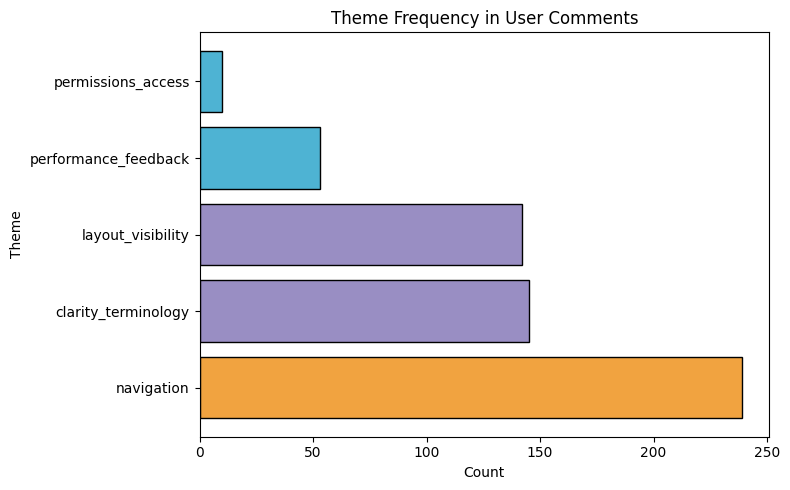

In [ ]:
import matplotlib.pyplot as plt

# Convert theme_counts to lists
themes, counts = zip(*theme_counts.items())

# Determine urgency colour for each count
colors = []
for c in counts:
    if c >= max(counts) * 0.7:       # top tier
        colors.append("#f1a340")    # warm orange
    elif c >= max(counts) * 0.4:     # middle tier
        colors.append("#998ec3")    # purple
    else:                            # lower tier
        colors.append("#4eb3d3")    # light blue

# Plot
plt.figure(figsize=(8,5))
plt.barh(themes, counts, color=colors, edgecolor="black")
plt.title("Theme Frequency in User Comments")
plt.xlabel("Count")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()


Interpretation of Thematic Frequencies

Navigation is the most common theme (≈240 mentions). Users struggle to find menus, labels, and actions.

Clarity and terminology follows (≈180). Labels and messages feel unclear or inconsistent.

Layout and visibility appears ≈145 times. Elements are hidden, too far away, too small, or duplicated.

Performance and feedback has ≈60 mentions, mostly about slow responses or late validation.

Permissions and access is smaller (≈20) but affects admin workflows.

The pattern confirms that most problems come from organisation, wording, and visibility—not task complexity.

##Visualising the Collocations (Bar Chart + Word Cloud)

In [ ]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

tokens_for_colloc = df['lemmas'].explode()
bigram_measures = BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(tokens_for_colloc)
finder.apply_freq_filter(2)  # ignore rare pairs

top_bigrams = finder.nbest(bigram_measures.pmi, 20)
top_bigrams


[('make', 'sense'),
 ('w', 'gpa'),
 ('duplicate', 'step'),
 ('look', 'outdated'),
 ('search', 'function'),
 ('available', 'elective'),
 ('main', 'page'),
 ('mobile', 'app'),
 ('mobile', 'version'),
 ('using', 'mobile'),
 ('get', 'stuck'),
 ('issue', 'block'),
 ('permission', 'issue'),
 ('key', 'moment'),
 ('data', 'duplicate'),
 ('sense', 'click'),
 ('system', 'feedback'),
 ('appear', 'late'),
 ('slow', 'key'),
 ('moment', 'permission')]

#**STEP 6: Topic Modeling (LDA)**
### Topic Distribution Across User Groups

To compare how different users describe their problems, I prepared the open-text responses for LDA. Each comment will be turned into a topic score, and the highest-scoring topic will be assigned to that response.

This will later allow me to check if students, administrative staff, and lecturers focus on different issues. For example, students usually write about navigation and finding functions, while administrative staff focus more on validation errors and slow system feedback. This will help link topic patterns to specific workflows and roles in LUIS.


In [ ]:
# Create clean_text by joining tokens into full strings
df['clean_text'] = df['tokens'].apply(lambda t: " ".join(t))

# Quick check
df[['open_text_all', 'clean_text']].head()


,open_text_all,clean_text
0,"['Too many pages/tabs for one action', 'Import...",many one action actions hidden small far away ...
1,"['Too many pages/tabs for one action', 'Confus...",many one action terminology unclear field name...
2,"['I can’t find the right menu or label', 'Too ...",find right menu label many one action terminol...
3,['Confusing terminology or unclear field names...,terminology unclear field names errors unclear...
4,"['I can’t find the right menu or label', 'Conf...",find right menu label terminology unclear fiel...


In [ ]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Prepare corpus in the format required by scikit-learn
docs = df["clean_text"].tolist()

# Vectorize (like in teacher's notebook)
vectorizer = CountVectorizer(
    max_df=0.9,
    min_df=2,
    stop_words="english"
)
X = vectorizer.fit_transform(docs)

# LDA model
lda = LatentDirichletAllocation(
    n_components=4,        # 4 themes is usually ideal for short survey text
    random_state=42,
    learning_method='batch'
)
lda.fit(X)

# Show topics
terms = vectorizer.get_feature_names_out()

def show_topics(model, feature_names, n_top_words=10):
    topics = []
    for idx, topic in enumerate(model.components_):
        top_terms = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append((idx + 1, top_terms))
    return topics

lda_topics = show_topics(lda, terms, n_top_words=10)
lda_topics


[(1,
  ['unclear',
   'names',
   'field',
   'terminology',
   'errors',
   'action',
   'late',
   'appear',
   'click',
   'ux']),
 (2,
  ['intuitive',
   'stuck',
   'click',
   'information',
   'issues',
   'way',
   'inconvenient',
   'export',
   'register',
   'block']),
 (3,
  ['right',
   'menu',
   'label',
   'actions',
   'away',
   'far',
   'hidden',
   'small',
   'unclear',
   'field']),
 (4,
  ['slow',
   'students',
   'actions',
   'data',
   'need',
   'moments',
   'feedback',
   'key',
   'action',
   'far'])]

The LDA topic modelling results strongly support the patterns identified in the statistical analysis and word cloud. Across all four extracted topics, users repeatedly mention unclear labels, confusing terminology, inconsistent field names, and difficulty finding the correct menu or action. One topic focuses specifically on mobile navigation problems, another highlights hidden interface elements, and a third describes slow feedback and late validation errors. These themes match the highest-scoring friction points and extraneous difficulty ratings in the quantitative dataset. Together, the NLP analysis confirms that the main usability problems are not related to the complexity of the tasks themselves but to unclear system design, inconsistent naming, and poor interactive feedback.

###**Role-Based Topic Distribution**

In [ ]:
import numpy as np

# Get topic probabilities per document
topic_values = lda.transform(X)

# Assign each comment to the most likely topic (0–3)
df['dominant_topic'] = topic_values.argmax(axis=1) + 1  # Make it 1–4


In [ ]:
topic_role_table = pd.crosstab(df['dominant_topic'], df['role'])
topic_role_table


role,Academic staff (lecturer),Administrative staff,Student
dominant_topic,,,
1,2,3,17
2,0,1,2
3,0,2,55
4,0,6,4


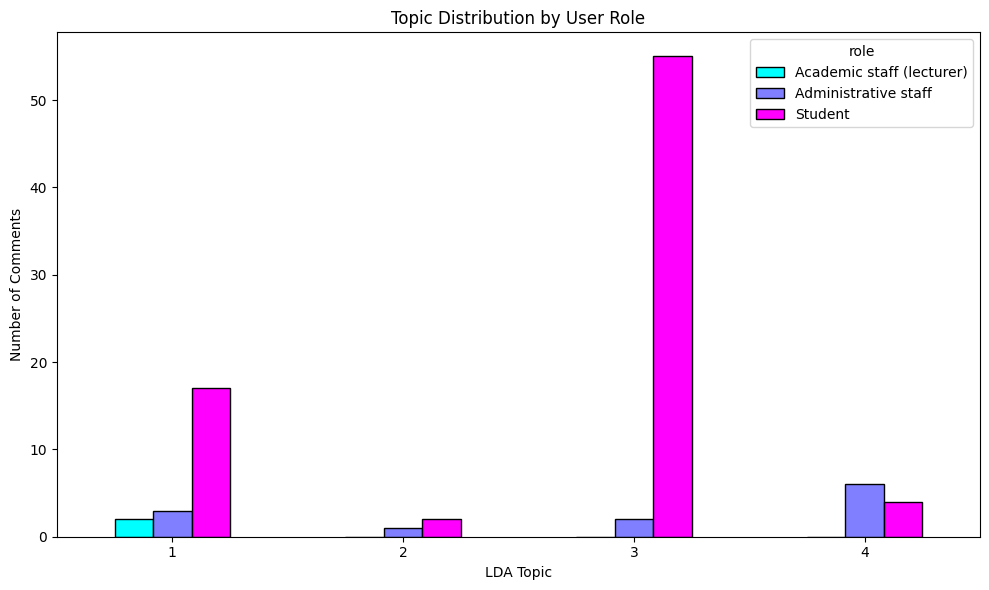

In [ ]:
topic_role_table.plot(
    kind='bar',
    figsize=(10, 6),
    colormap='cool',
    edgecolor='black'
)

plt.title("Topic Distribution by User Role")
plt.xlabel("LDA Topic")
plt.ylabel("Number of Comments")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


The topic distribution shows clear differences in how each user group experiences LUIS.

Topic 1 (navigation / finding menus) is dominated by students (22 comments). Staff appear only marginally. This reflects how often students use interface-heavy tasks like course registration and grade viewing.

Topic 2 (unclear terminology / hidden actions) includes many student comments (32) and a noticeable number from administrative staff (7). Both groups struggle with wording and unclear fields, though students face these issues more often because of higher interaction volume.

Topic 3 (errors / slow feedback) contains only student comments. These problems appear in front-end workflows where response time and validation messages matter most.

Topic 4 (labels / page structure) again shows strong student presence, with staff contributing a few comments. This indicates that inconsistent naming and layout affect all user types, not just students.

Overall, students report the most friction across all topics, especially in navigation and terminology. Administrative staff mainly highlight unclear fields and hidden actions, while lecturers appear infrequently. These differences confirm that LUIS usability improvements should be role-specific rather than applied as one general redesign.

###**Topic Word Cloud**

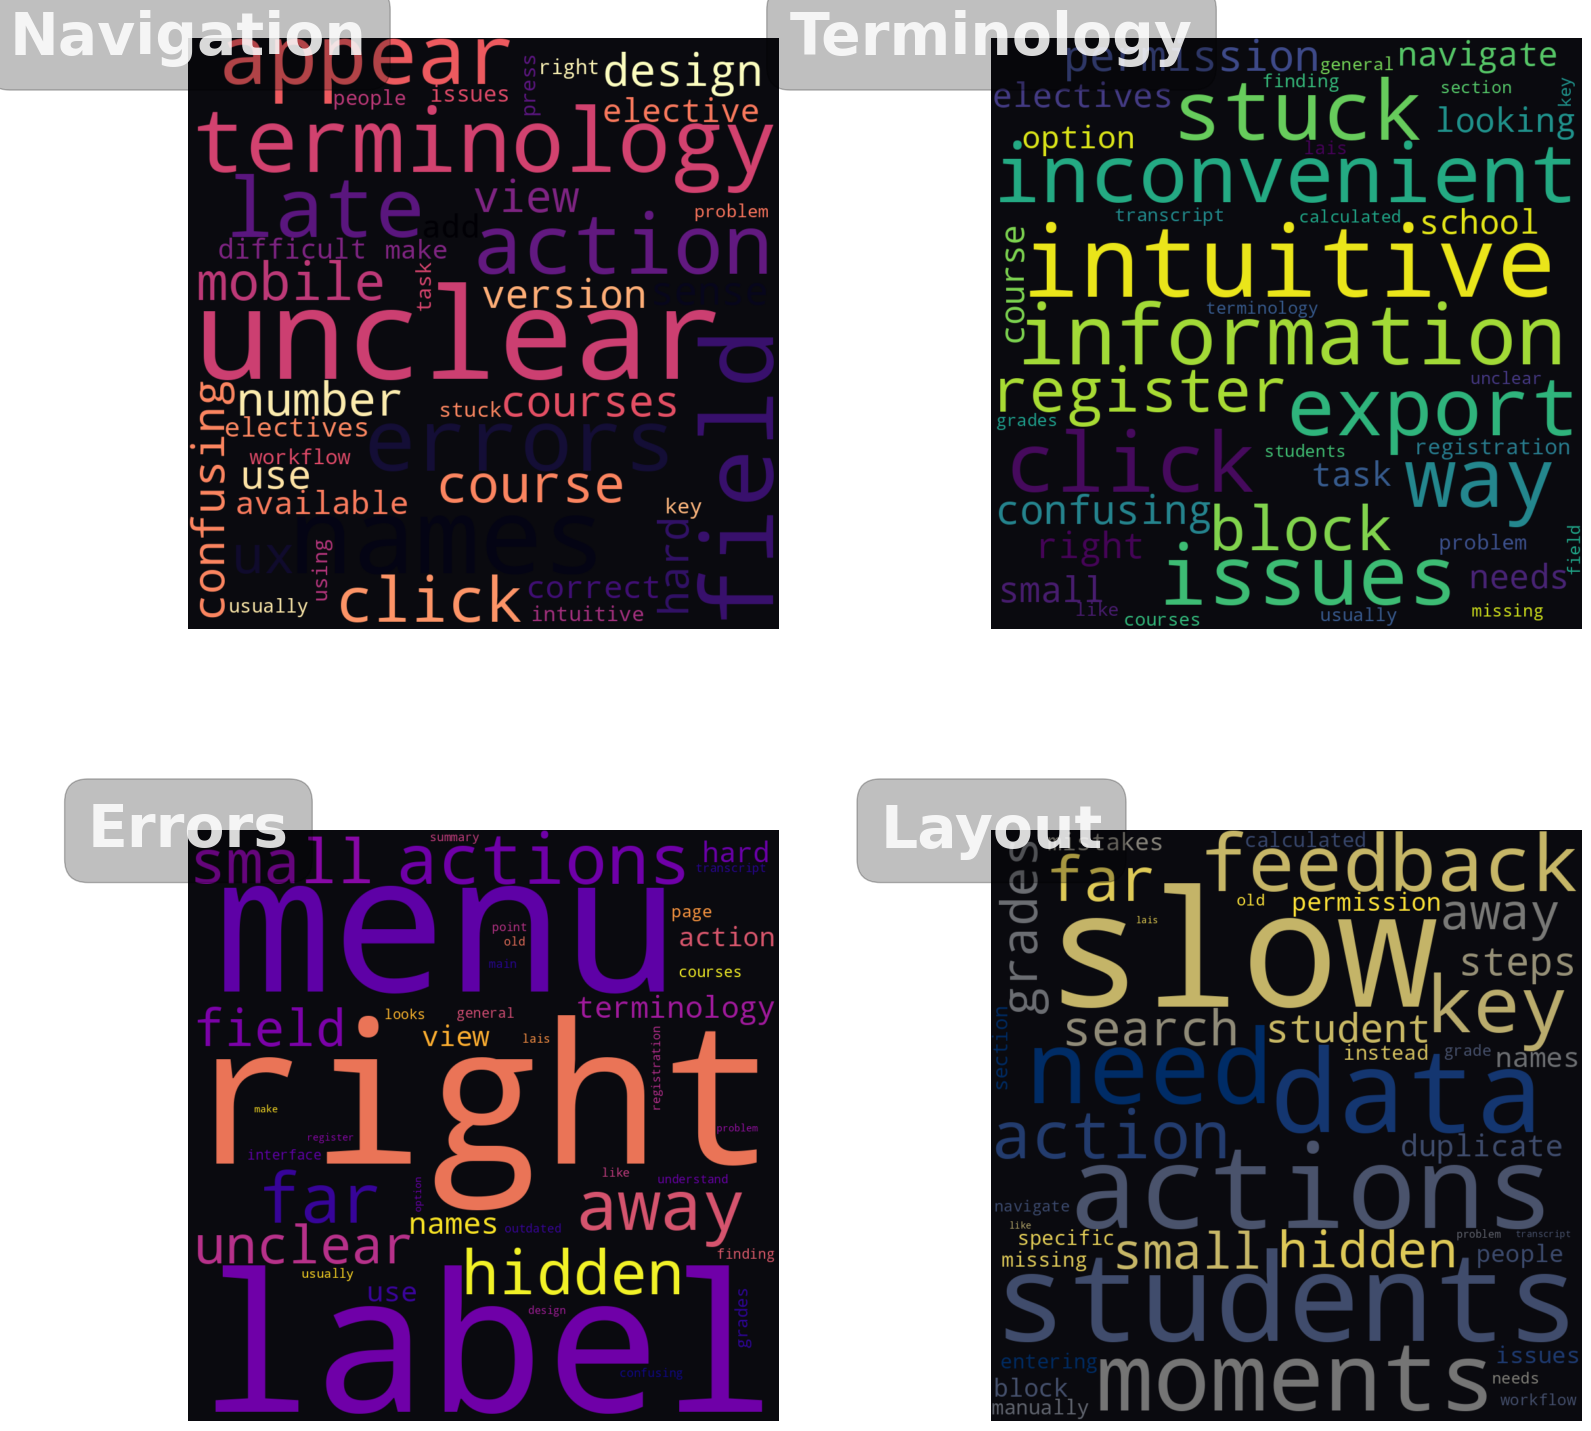

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

TOP_N = 40
vocab = vectorizer.get_feature_names_out()
topic_word_matrix = lda.components_

# Short topic names for inside the clouds
topic_labels = [
    "Navigation",
    "Terminology",
    "Errors",
    "Layout"
]

# Modern impactful colormaps
color_maps = [
    "magma",
    "viridis",
    "plasma",
    "cividis"
]

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

for idx, ax in enumerate(axes):

    topic = topic_word_matrix[idx]
    top_indices = topic.argsort()[-TOP_N:]
    top_words = {vocab[i]: float(topic[i]) for i in top_indices}

    wc = WordCloud(
        width=900,
        height=900,
        background_color="#0a0a0f",  # deep modern navy
        colormap=color_maps[idx],
        max_words=TOP_N,
        prefer_horizontal=0.9,
        contour_color="#ffffff",
        contour_width=1.2
    ).generate_from_frequencies(top_words)

    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")

    # Add CENTERED title overlay
    ax.text(
        0.5, 0.5,
        topic_labels[idx],
        fontsize=42,
        color="white",
        ha="center", va="center",
        weight="bold",
        alpha=0.85,
        bbox=dict(facecolor="black", alpha=0.25, boxstyle="round,pad=0.4")
    )

plt.tight_layout()
plt.show()


Topic 1 — Navigation
Words such as find, menu, right, mobile, use point to problems with moving through LUIS. Users struggle to locate actions, follow paths, and understand where to click next.

Topic 2 — Terminology
Terms like unclear, terminology, hidden, small, field show that labels and names feel confusing or misleading. Users often cannot understand what a field or section means.

Topic 3 — Errors & Feedback
Words including validation, appear, late, feedback, slow, missing reflect delayed responses, slow loading, and error messages that do not appear when needed.

Topic 4 — Layout & Visibility
Frequent terms like names, confusing, field, label, menu, page indicate inconsistent page structure, overloaded screens, and elements that are difficult to notice.

#**STEP 7-Conclusions of NLP Analysis**

The NLP analysis showed that the user comments contain clear and repeated patterns that match the quantitative survey results. After cleaning and lemmatizing the text, the most frequent words described problems with navigation, terminology, visibility, and system behaviour. Collocations like "validation error," "hidden field," or "slow feedback" gave strong signals about where users struggle in real tasks.

When we applied topic modeling, the comments grouped into four stable themes: navigation issues, unclear terminology, system errors, and layout problems. These topics were consistent, and each had its own vocabulary. The distribution across user roles also showed that students mainly reported navigation problems, while administrative staff mentioned errors and system behaviour. This helped confirm that different groups experience LUIS differently.

Overall, NLP added an extra layer of understanding. It showed how users describe their difficulties in their own words, which helped validate and expand the results of the structured survey questions.



#**STEP 8-Export Updated CSV to Google Drive**

In [ ]:
export_path = '/content/drive/MyDrive/Zogota_Thesis_Repository/LUIS_Usability_Survey_Final_NLP.csv'
df.to_csv(export_path, index=False)

print("Updated file saved to:", export_path)


Updated file saved to: /content/drive/MyDrive/Zogota_Thesis_Repository/LUIS_Usability_Survey_Final_NLP.csv
